# Generalization

This last notebook aims to evaluate the generalization capability of the developed classification models in distinguishing between evergreen and deciduous trees.

In the previous experiments, the dataset was optimized for spectral band combinations and compositing methods. The hyperparameters of multiple classification models were optimized using this dataset. The models were then trained on the complete dataset.

In this notebook, we test the abilities of all models to generalize to unseen areas and compare their performance with the DLT (Dominant Leaf Type) 2018 dataset, a benchmark derived from inventory data.

We use the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein) as the experimental site for this evaluation. The plot is located near to the Bavarian Alps, Germany, and is part of the [ForestGEO](https://forestgeo.si.edu/) network. You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31) and convert it by yourself to the CSV format described in the "Ground Truth" notebook. 

We start by analyzing the recording dates of the plot:

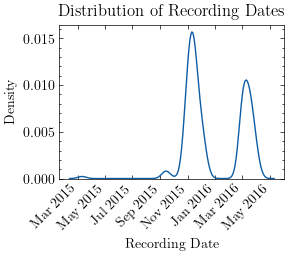

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots  # noqa: F401
import seaborn as sns
from matplotlib import dates as mdates

from slc.visualize import save_fig

plt.style.use(["science"])

# Plot all recording dates
fig, ax = plt.subplots(figsize=(5.81 / 2, 2))
sns.kdeplot(
    pd.read_csv("../data/interim/test/traunstein.csv")["date"].astype("datetime64[ns]"),
    ax=ax,
)
ax.set_title("Distribution of Recording Dates")
ax.set_xlabel("Recording Date")
ax.set_ylabel("Density")
plt.xticks(rotation=45, ha="right")
ax.tick_params(axis="x", which="minor", length=0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

save_fig(fig, f"../reports/figures/generalization/{ax.get_title()}.pdf")

The dataset was collected between 2015 and 2016, which may result in some limitations when using it as ground truth for the closest available Level-2A data from 2018. However, it remains valuable for assessing the generalization capabilities of our models, particularly because it covers the region of interest — the temperate climate zone of Bavaria.

Additionally, the dataset's large spatial extent enables further visual analysis. It is also important to note that the forest composition in this region is not expected to have undergone significant changes over the two-year period between recording and the Sentinel-2 data.

We compute the ground truth from the plot data:

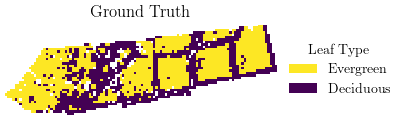

In [2]:
# Plot ground truth
from logging import INFO
from pathlib import Path
from sys import stdout

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from loguru import logger
from matplotlib.cm import viridis
from matplotlib.patches import Patch

from slc.data import compute_target
from slc.features import genera2target_raster

logger.configure(handlers=[{"sink": stdout, "format": "{message}", "level": INFO}])

target_path = Path("../data/processed/generalization/traunstein_target.tif")
binary_path = target_path.parent / "traunstein_binary.tif"
target_path.parent.mkdir(parents=True, exist_ok=True)

if not target_path.exists():
    plot = pd.read_csv("../data/interim/test/traunstein.csv")

    compute_target(target_path, plot)
    genera2target_raster(target_path, dst_path=binary_path)

# Prepare the colormap
cmap = viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# Create subplot and colorbar
fig, ax = plt.subplots()

# Load the target raster
with rasterio.open(binary_path) as ds_reader:
    target_raster = ds_reader.read()

# Plot the target raster
ax.imshow(
    target_raster.transpose(1, 2, 0),
    interpolation="nearest",
    cmap=cmap,
    norm=norm,
)
ax.axis("off")
ax.set_title("Ground Truth")

ax.legend(
    handles=[
        Patch(facecolor=viridis.get_over(), label="Evergreen"),
        Patch(facecolor=viridis.get_under(), label="Deciduous"),
    ],
    title="Leaf Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

plt.show()

We create the Sentinel-2 composites according to the methodology derived in the band importance and compositing experiments. We predict on this satellite data using the tuned models from the previous experiment:

In [3]:
# Compute data and load the models
import dill

from slc.models import create_data

data_folder = Path("../data/processed/generalization/traunstein_data/")
year = 2018
data_folder.mkdir(parents=True, exist_ok=True)

data_path = data_folder / f"{year}/data.tif"

if not data_path.exists():
    create_data(
        year=year,
        target_path=target_path,
        data_folder=data_folder,
        top_n=10,
    )

# Load the models
tuning_df = pd.read_csv("../reports/hyperparameter_tuning.csv", index_col=0)
model_paths = [Path(f"../models/{model}.pkl") for model in tuning_df.index]

tuned_models = []
for model_path in model_paths:
    with model_path.open("rb") as file:
        model = dill.load(file)  # noqa: S301
        tuned_models.append(model)

/Users/peterhofinger/miniforge3/envs/slc/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [11:06:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232611148/work/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


  0%|          | 0/8 [00:00<?, ?it/s]

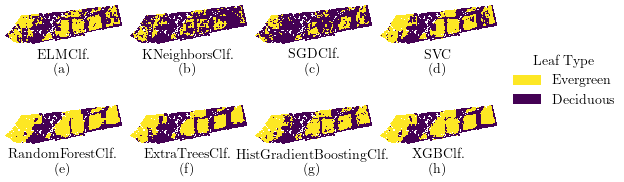

In [4]:
# Plot the predictions of all models
import numpy as np
from tqdm.notebook import tqdm

from slc.features import load_raster
from slc.visualize import label_subplots

model_folder = Path("../data/processed/generalization/")
model_folder.mkdir(parents=True, exist_ok=True)
fig, axs = plt.subplots(2, 4, figsize=(5, 2), constrained_layout=True)

prediction_rasters = []
for ax, model in tqdm(list(zip(axs.flatten(), tuned_models, strict=False))):
    path = model_folder / f"{model.steps[-1][1].__class__.__name__}.tif"
    if Path(path).exists():
        with rasterio.open(path) as ds_reader:
            prediction_raster = ds_reader.read()
    else:
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        data = load_raster(data_path, monochrome_as_dataframe=True)
        prediction_raster = model.predict(data)
        with rasterio.open(binary_path) as ds_reader:
            profile = ds_reader.profile
            shape = ds_reader.read().shape
            nan_or_larix = np.isnan(ds_reader.read())

        prediction_raster = prediction_raster.reshape(shape).astype(float)
        prediction_raster[nan_or_larix] = np.nan

        with rasterio.open(path, "w", **profile) as dst:
            dst.write(prediction_raster)

    prediction_rasters.append(prediction_raster)

    im = ax.imshow(
        prediction_raster.transpose(1, 2, 0),
        interpolation="nearest",
        cmap=cmap,
        norm=norm,
    )
    ax.set(xticks=[], yticks=[])
    ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
    model_name = model.steps[-1][1].__class__.__name__
    model_name = model_name.replace("Classifier", "Clf.")
    ax.set_xlabel(model_name)

label_subplots(axs.flatten(), y_offset=0.5)

fig.legend(
    handles=[
        Patch(facecolor=viridis.get_over(), label="Evergreen"),
        Patch(facecolor=viridis.get_under(), label="Deciduous"),
    ],
    title="Leaf Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

save_fig(fig, "../reports/figures/generalization/Model Predictions.pdf")

The predictions of all models differ from each other and the ground truth. The differences between the models are attributable to the different algorithms behind the models themselves. For example the K-Nearest Neighbor classifier classifies too many pixels as deciduous which can be attributed to the high amount of deciduous pixels in the training data.

The differences between the predictions and the ground truth might be attributed to the geolocation uncertainty of the Sentinel-2 data. The ground truth contains a visually more noisy pattern, which is expected due to the high quality dataset, which reflects any local change in composition from one pixel to another. The predictions are based on the Sentinel-2 data, whose geolocation uncertainty might introduce a blur like effect in the time series data and thus in the predictions.

The absolute geolocation uncertainty of Sentinel 2 is [no greater than 20 meter 2 $\sigma$](https://sentiwiki.copernicus.eu/web/s2-mission#S2Mission-GeometricPerformanceS2-Mission-Geometric-Performancetrue) without GCPs, with the latest annual performance report for 2023 reporting an absolute geolocation [better than 6 meters](https://sentiwiki.copernicus.eu/__attachments/1673423/OMPC.CS.APR.003%20-%20S2%20MSI%20Annual%20Performance%20Report%202023%20-%201.0.pdf?inst-v=9ad58ac0-a8e1-4d1a-9b7f-e474a46e68f3) for the L1C data.

Now we analyze the prediction quality of the best model. We choose the best model by the highest F1 score, which is the Histogram-based Gradient Boosting classifier. We plot the bootstrapped f1 scores of the predictions across the tree heights in a 5 meter rolling window. The heights are taken from a normalized digital elevation model (nDEM) of the plot area, downsamples by computing the median per 10m x 10m pixel:

In [5]:
import numpy as np
from sklearn.metrics import f1_score

from slc.models import rolling_window


def _f1_stats(data: pd.DataFrame) -> dict:
    target = data["Target"].to_numpy()
    prediction = data["Prediction"].to_numpy()

    point_estimate = f1_score(target, prediction)

    n_resamples = 1000
    alpha = 0.95
    index = np.arange(target.size)
    resamples = np.random.default_rng().choice(
        index, size=(n_resamples, index.size), replace=True
    )

    # Vectorized computation of resampled F1 scores
    resampled_f1s = np.array(
        [f1_score(target[resample], prediction[resample]) for resample in resamples]
    )

    lower_bound, upper_bound = np.percentile(
        resampled_f1s, [(1 - alpha) / 2 * 100, (1 + alpha) / 2 * 100]
    )

    return {
        "Point Estimate": point_estimate,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
    }


f1_scores = []
target = load_raster(binary_path)
for prediction in prediction_rasters:
    mask = target.notna()

    f1_scores.append(f1_score(target[mask], prediction.flatten()[mask]))

best_idx = np.argmax(f1_scores)
best_model = tuned_models[best_idx].steps[-1][1].__class__.__name__

dem = load_raster("../data/external/dem_median.tif")
target = load_raster("../data/processed/generalization/traunstein_binary.tif")
prediction = load_raster(f"../data/processed/generalization/{best_model}.tif")

data = pd.DataFrame({"Target": target, "Prediction": prediction})

mask = target.notna()
dem = dem[mask]
data = data[mask]

result_path = Path("../reports/rolling_window.csv")
if not result_path.exists():
    result = rolling_window(
        dem, data, window_width=5, function=_f1_stats, n_samples=200
    )
    result.to_csv(result_path)
else:
    result = pd.read_csv(result_path, index_col=0)

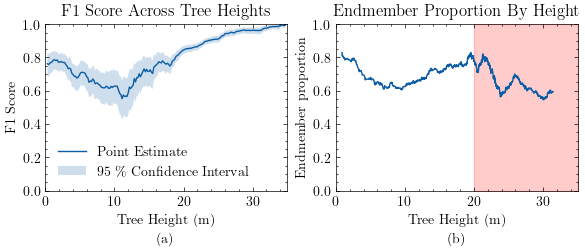

In [6]:
# Plot the percentage of endmembers across the height of the trees
from slc.features import genera2target, load_raster
from slc.visualize import label_subplots

x = result.index
point_estimate = result["Point Estimate"]
lower_bound = result["Lower Bound"]
upper_bound = result["Upper Bound"]

fig, axs = plt.subplots(ncols=2, figsize=(5.81, 2.5), constrained_layout=True)
ax = axs[0]
ax.plot(x, point_estimate)
ax.fill_between(x, lower_bound, upper_bound, alpha=0.2)
ax.set_ylim(0, 1)
ax.set_xlim(0, 35)
ax.set_xlabel("Tree Height (m)")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Score Across Tree Heights")
ax.legend(["Point Estimate", r"95 \% Confidence Interval"])

window_size = 200

target = load_raster("../data/processed/generalization/traunstein_target.tif")
regression_target = genera2target(target, regression=True).copy()
regression_target["evergreen proportion"] = regression_target[
    "evergreen"
] / regression_target.sum(axis=1)

dem = load_raster("../data/external/dem_median.tif")

target_df = regression_target[
    "evergreen proportion"
].copy()  # pd.Series(target_raster.flatten())
prediction_df = pd.Series(prediction_rasters[best_idx].flatten())
dem_df = pd.Series(dem.values)

mask = target_df.notna()
target_df, prediction_df, dem_df = target_df[mask], prediction_df[mask], dem_df[mask]

endmembers = ((target_df != 0) & (target_df != 1)).astype(int)

dem_df = dem_df.reset_index(drop=True)
endmembers = endmembers.reset_index(drop=True)
indices = dem_df.argsort()
endmembers, dem_df = endmembers[indices], dem_df[indices]
moving_average = endmembers.rolling(window_size, center=True).mean()

ax = axs[1]
ax.fill_betweenx([0, 1], 20, 35, color="r", alpha=0.2)
ax.plot(dem_df, 1 - moving_average)
ax.set_ylim(0, 1)
ax.set_xlim(0, 35)
ax.set_xlabel("Tree Height (m)")
ax.set_ylabel("Endmember proportion")
ax.set_title("Endmember Proportion By Height")

label_subplots(axs, y_offset=0.25)

save_fig(fig, "../reports/figures/generalization/Height Analysis.pdf")

Prediction quality is notably lower for smaller trees, particularly for those pixels with a median height below 20 meters. Both the point estimates and confidence intervals indicate a decline in performance at these heights.

One possible explanation for this trend is the increasing proportion of endmembers as tree height increases. An endmember is defined as a pixel consisting exclusively of a single leaf type, based on its base area.

To explore this hypothesis, we will examine the relationship between tree height and the amount of endmembers. For this purpose, we plotted the count of endmembers per tree height, where endmembers are defined as pixels that are pure pixels.

The first dip in prediction quality appears to correlate with the low proportion of endmembers for smaller trees around 10 meters height. However, for larger trees, the relationship between endmember proportion and prediction quality is less straightforward.

The improvement in prediction performance for trees taller than 20 meters may be due to reduced noise from surrounding vegetation. Smaller trees might allow more interference from underlying vegetation, while taller trees cover a pixel more completely, minimizing the effect of background vegetation.

# Comparison with DLT 2018

To assess the quality of our predictions in relation to other research, we compare them against the DLT 2018 product. The [Dominant Leaf Type 2018](https://land.copernicus.eu/en/products/high-resolution-layer-dominant-leaf-type/dominant-leaf-type-2018) product is available for download from the Copernicus Land Monitoring Service.

The dataset provides information on the dominant leaf type of forested areas across Europe, including the Bavarian Alps. The dominant leaf type definition of the dataset distinguishes between conifers and broadleaf trees. This causes an inconsistency for the Larix genus. For this reason we ignore all pixels containing Larix for the DLT dataset while using all pixels to evaluate our models on the Traunstein plot.

We first show the ground truth data, the prediction of our best model, and the DLT 2018 data:

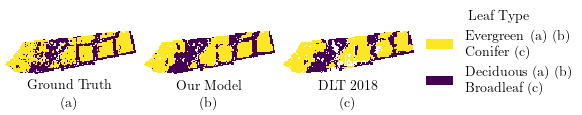

In [7]:
# Predict on new data with the best model
import rasterio
from matplotlib.cm import viridis
from matplotlib.patches import Patch

from slc.data import download_dlt_2018
from slc.visualize import plot_rasterio

fig, axs = plt.subplots(1, 3, figsize=(5.81, 2), constrained_layout=True)

with rasterio.open(binary_path) as src:
    plot_rasterio(
        src,
        title="Ground Truth",
        ax=axs[0],
    )

best_model = tuned_models[best_idx].steps[-1][1].__class__.__name__
prediction_path = model_folder / f"{best_model}.tif"
with rasterio.open(prediction_path) as ds_reader:
    plot_rasterio(
        ds_reader,
        title="Our Model",
        ax=axs[1],
    )

    nan_or_larix = np.isnan(ds_reader.read())

dlt_2018_path = Path("../data/external/dlt_2018.tif")
if not dlt_2018_path.exists():
    download_dlt_2018(binary_path, dlt_2018_path, use_mask=True)

contains_larix = load_raster(target_path)["Larix"] > 0
with rasterio.open(dlt_2018_path) as ds_reader:
    plot_rasterio(ds_reader, title="DLT 2018", ignore_mask=contains_larix, ax=axs[2])

handles = [
    Patch(facecolor=viridis.get_over(), label="Evergreen (a) (b)\nConifer (c)"),
    Patch(facecolor=viridis.get_under(), label="Deciduous (a) (b)\nBroadleaf (c)"),
]

axs[2].legend(
    handles=handles,
    title="Leaf Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

label_subplots(axs, y_offset=0.5)

save_fig(fig, "../reports/figures/generalization/Prediction Comparison.pdf")

# Metrics and Confusion Matrix

We compare the predictions from our classification models against the DLT 2018 product. This comparison is done using accuracy, F1 score, Cohen's kappa, as well as the confusion matrix for our best model and the DLT 2018 product:

,F1 Score,Accuracy,Kappa
Method,,,
ELMClassifier,0.732,0.725,0.464
KNeighborsClassifier,0.523,0.600,0.268
SGDClassifier,0.522,0.606,0.282
SVC,0.799,0.784,0.570
RandomForestClassifier,0.855,0.828,0.644
ExtraTreesClassifier,0.830,0.817,0.635
HistGradientBoostingClassifier,0.823,0.805,0.608
XGBClassifier,0.857,0.831,0.652
DLT 2018,0.853,0.819,0.617


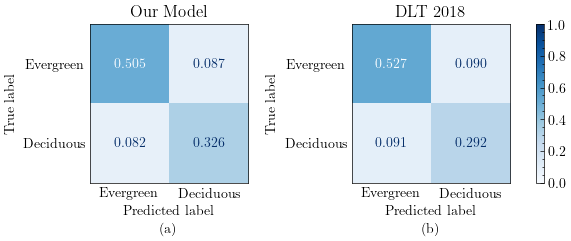

In [8]:
# Compare our models with DLT 2018 for each metric, ignoring pixels containing Larix for DLT 2018
from matplotlib.cm import Blues, ScalarMappable
from matplotlib.colors import Normalize
from sklearn.base import ClassifierMixin
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix


def _evaluate_model(
    model: ClassifierMixin, target: pd.Series, model_folder: Path
) -> tuple:
    model_name = model.steps[-1][1].__class__.__name__
    prediction = load_raster(model_folder / f"{model_name}.tif")[target.notna()]
    masked_target = target[target.notna()]

    f1 = f1_score(masked_target, prediction)
    acc = accuracy_score(masked_target, prediction)
    kappa = cohen_kappa_score(masked_target, prediction)
    cm = confusion_matrix(masked_target, prediction)

    return model_name, f1, acc, kappa, cm


def _confusion_matrix_display(
    cm: np.ndarray,
    title: str,
    labels: list,
    mappable: ScalarMappable,
    ax: mpl.axes.Axes | None = None,
) -> None:
    cmap = mappable.get_cmap()
    norm = mappable.norm

    ax.imshow(cm, interpolation="nearest", cmap=cmap, norm=norm)

    # Set axis labels
    ax.set(
        title=title,
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Add text annotations inside the confusion matrix
    center = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], ".3f"),
                ha="center",
                va="center",
                color=cmap.get_over() if norm(cm[i, j]) < center else cmap.get_under(),
            )

    ax.tick_params(axis="both", which="both", length=0)


target = load_raster(binary_path)
results = [_evaluate_model(model, target, model_folder) for model in tuned_models]

prediction = load_raster(dlt_2018_path)
mask = ~contains_larix & target.notna() & prediction.notna()
prediction = prediction[mask]
masked_target = target[mask]

results.append(
    (
        "DLT 2018",
        f1_score(masked_target, prediction),
        accuracy_score(masked_target, prediction),
        cohen_kappa_score(masked_target, prediction),
        confusion_matrix(masked_target, prediction),
    )
)

results = pd.DataFrame(
    results, columns=["Method", "F1 Score", "Accuracy", "Kappa", "Confusion Matrix"]
)
results = results.set_index("Method")
results.to_csv("../reports/generalization.csv")

# Show confusion matrices of best_model and DLT 2018
display_labels = ["Deciduous", "Evergreen"]
subset = results.loc[[best_model, "DLT 2018"]]
fig, axs = plt.subplots(1, len(subset), figsize=(5.81, 2.4), constrained_layout=True)

cmap = Blues
norm = Normalize(vmin=0, vmax=1)
mappable = ScalarMappable(norm=norm, cmap=cmap)

for ax, (method, row) in zip(axs, subset.iterrows(), strict=True):
    cm = row["Confusion Matrix"]
    cm = cm / cm.sum()
    cm = cm[::-1, ::-1]

    _confusion_matrix_display(
        cm,
        "Our Model" if method == best_model else method,
        display_labels[::-1],
        mappable=mappable,
        ax=ax,
    )

fig.colorbar(mappable, ax=axs.ravel().tolist())

label_subplots(axs, y_offset=0.25)

save_fig(fig, "../reports/figures/generalization/Confusion Matrices.pdf")

formatted_results = results[["F1 Score", "Accuracy", "Kappa"]].copy()
results[["F1 Score", "Accuracy", "Kappa"]].map(lambda x: f"{x:.3f}")

It is important to note that the confusion matrix for the DLT 2018 product includes fewer samples because pixels containing the Larix genus are excluded.

Our chosen model, the optimized Random Forest classifier, outperforms the DLT 2018 product across all metrics. The model achieves an F1 score of 0.86, an accuracy of 0.84, and a Cohen's kappa of 0.68. In comparison, the DLT 2018 product has an F1 score of 0.85, an accuracy of 0.82, and a Cohen's kappa of 0.62.

At last, we list the optimized parameters of our best model: 

In [9]:
# Show tuned parameters of best model
model_path = Path(f"../models/{best_model}_study.pkl")

with model_path.open("rb") as file:
    model = dill.load(file)  # noqa: S301

model.best_params

{'do_standardize': False,
 'do_pca': False,
 'n_estimators': 72,
 'max_depth': 3,
 'learning_rate': 0.49383803830282824,
 'gamma': 0.15008478561153937,
 'min_child_weight': 8,
 'reg_alpha': 49,
 'reg_lambda': 0.28896237940409775,
 'colsample_bytree': 0.6267280712530368}

## Conclusion

The results demonstrate that our classification model generalizes effectively, even in unseen test areas and years, outperforming the DLT 2018 product. The model reliably differentiates between evergreen and deciduous trees. The confusion matrix shows a tendency of our model to classify pixels as deciduous, likely reflecting the higher proportion of deciduous trees in the training data.

A key advantage of our approach over DLT 2018, aside from the different leaf type definitions, is its applicability to all years. It can be used with Sentinel-2 data from any year and will deliver consistent performance, thanks to our multi-year training data and advanced composite generation.

As Sentinel-2 data's geospatial accuracy improves with time, we anticipate that our approach will also benefit from more recent training and inference data. Future work could explore additional compositing methods to further improve classification accuracy.

Our method is designed for trees greater than 20 meters in height and is robust to temporal changes. The Traunstein plot will be revisited throughout 2024, and if new data is released, we will apply our model to it.

We conclude that our model is a reliable tool for distinguishing between evergreen and deciduous trees in temperate forests, especially for trees above 20 meters in height. The advanced compositing methods and optimized classification models contribute to the model's high performance and generalization capabilities to unseen areas and years.